In [1]:
#code for webscraping and data cleaning not included but is available on github
import pandas as pd
import numpy as np
import seaborn as sns
from dateutil.parser import parse
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn import pipeline
from statsmodels.tsa.arima_model import ARIMA as ar
from itertools import permutations
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import Normalizer
import warnings
warnings.filterwarnings('ignore')
sns.set()
plt.rcParams.update({'font.size': 22,'figure.dpi':144})

START_DATE='2001-01-01'
END_DATE = '2020-01-01'

In [2]:
gpu_df = pd.read_pickle("../../data/preprocessed_data/final_gpu_df.pkl")
cpu_df = pd.read_pickle("../../data/preprocessed_data/final_cpu_df.pkl")

'game requirements'
req_df = pd.read_excel("../../data/preprocessed_data/preprocessed game requirements.xlsx", header = [0,1], index_col = [0])

In [3]:
"Set index to date column"
def set_time_index(df, date_col):
    """
    df is the dataframe to be re_indexed 
    date_col is a tuple of the the date containing column
    """
    new_df = df.set_index(date_col).copy()
    new_df = new_df.sort_index()
    "add a small time adjustment to prevent any duplicated indices"
    time_steps = pd.to_timedelta(np.arange(len(df)), 'S')
    new_index = new_df.index + time_steps
    new_df.index = new_index
    new_df = new_df[START_DATE:END_DATE]
    return new_df

def resampler(df, resample_period="2Q"):
    df = df.apply(np.log)
    return pd.DataFrame([df.resample(resample_period).quantile(x) for x in [.5,.75,.9]],
                          index = (['r50','r75','r90'])).transpose()

class recent_hardware(sk.base.BaseEstimator, sk.base.TransformerMixin):
    """
    takes in a component dataframe and returns the quantiles of the component
    from the component dataframe
    
    """
    def __init__(self,component_df,year_list=[1,2,3],quantiles = [.25,.5,.75,.9,.99]):
        self.df = component_df
        self.year_list = year_list
        self.quantiles = quantiles
        
    def fit(self,X,y=None):
        return self

    def transform(self, X):
        output = []
        for x in X:
            row = []
            for year in self.year_list:
                start_date = x-pd.Timedelta(days=year*365)
                end_date = start_date + pd.Timedelta(days=365)
                tmp_df = self.df[start_date:end_date]
                for quantile in self.quantiles:
                    row.extend(tmp_df.quantile(quantile))
            output.append(row)
                
        return np.array(output)
    
class recent_hardware2(sk.base.BaseEstimator, sk.base.TransformerMixin):
    """
    takes in a component dataframe and returns the quantiles of the component
    from the component dataframe
    
    """
    def __init__(self,component_df,years_back = 4,quantiles = [.5,.75,.9,.99]):
        self.df = component_df
        self.years_back = years_back
        self.quantiles = quantiles
        
    def fit(self,X,y=None):
        return self

    def transform(self, X):
        output = []
        for x in X:
            row = []
            start_date = x-pd.Timedelta(days=self.years_back*365)
            end_date = x
            tmp_df = self.df[start_date:end_date]
            for quantile in self.quantiles:
                row.extend(tmp_df.quantile(quantile))
            output.append(row)
                
        return np.array(output)
    
    
class indexer(sk.base.BaseEstimator, sk.base.TransformerMixin):
    """
    takes in a component dataframe and returns an index with each step incremented by 1
    
    """
    def __init__(self):
        pass
    
    def fit(self,X,y=None):
        self.train_start_date = X[0]
        self.freq = X.freq
        return self

    def transform(self, X):
        """
        the predict depends on the number of periods from the start of the training set to predict date
        this function must return the number corrisponding to the number of periods between the beginning
        of the training set and the dates on which a prediction is required
        """
        full_date_range = pd.date_range(start = self.train_start_date,
                                        end = X[-1],
                                        freq = self.freq)
        prediction_indices = np.arange(len(full_date_range))[-len(X):]
#         print(prediction_indices)
        return prediction_indices.reshape([-1,1])

class Time_cross_validation:
    def __init__(self,model,data,tested_periods = 10,min_periods = 4):
        """
        data is a pandas dataframe with one column
        tested_periods is how many periods are used to score the fit
        """
        self.model = model
        self.data = data
        self.tested_periods = tested_periods
        self.min_periods = min_periods
        
    def splits(self):
        window_start = self.min_periods
        window_end = len(self.data) - self.tested_periods + 1
        self.train_set = []
        self.test_set = []
        for index in range(window_start, window_end):
            self.train_set.append(self.data[0:index])
            self.test_set.append(self.data[index:index+self.tested_periods])
#         print([(x,y) for x,y in zip(self.train_set, self.test_set)])
        
    def score(self):
        """
        give the 
        """
#         r2 = []
        mse = []
        self.splits()
#         print (self.train_set)
        for X,Y in zip(self.train_set,self.test_set):
#             print(X)
            self.model.fit(X.index,X.values.reshape([-1,1]))
            predicts = self.model.predict(Y.index)
            ybar = np.mean(Y.values)
#             SStot = sum([(yi-ybar)**2 for yi in Y.values.flatten()])
            SSres = sum([(fi - yi)**2 for fi,yi in zip(predicts,Y.values.flatten())])
#             r2.append(1-SSres/SStot)
            mse.append(SSres)
        
#         print(f"fitted x values: {X.index}")
#         print(f"fitted y values: {X.values}")
#         print(f"Actual Values: {Y.values}")
#         print(f"Predicted_values {predicts.flatten()}")
#         print(f"Ybar {ybar}")
#         print(r2)
        return np.mean(mse)



In [4]:
class priors(sk.base.BaseEstimator, sk.base.TransformerMixin):
    """
    gives information about recent value trends
    
    """
    def __init__(self,game_df,nyears = 5,quantiles = [.9,.75,.5,.25]):
        self.nyears = nyears
        self.game_df = game_df.apply(np.log)
        self.quantiles = quantiles
        
    def fit(self,X,y=None):
        return self

    def transform(self, X):
        output = []
        for x in X:
            start_date = x-pd.Timedelta(days=self.nyears*365)
            end_date = x
            tmp_df = self.game_df[start_date:end_date]
#             print(tmp_df)
            row = []
            for quantile in self.quantiles:
#                 print(tmp_df.quantile(.95))
                row.append(tmp_df.quantile(quantile))
            output.append(row)
#         print(output)
        return np.array(output)

In [5]:
cpu_df_raw = cpu_df
gpu_df_raw = gpu_df

In [6]:
"Drop unused columns"
req_df = req_df[[('Game Info',"Release Date"),
            ('Minimum','gpu_tex'),('Recommended','gpu_tex'),
            ('Minimum','flops'),('Recommended','flops')]].copy()

"set index as a datetime for each dataframe"
req_df = set_time_index(req_df,('Game Info', 'Release Date'))
gpu_df = set_time_index(gpu_df.reset_index(),"Release Date")
cpu_df = set_time_index(cpu_df.reset_index(),"released")

"drop all na"
min_gpu_df = req_df['Minimum','gpu_tex'].dropna()
rec_gpu_df = req_df['Recommended','gpu_tex'].dropna()
min_cpu_df = req_df['Minimum','flops'].dropna()
rec_cpu_df = req_df['Recommended','flops'].dropna()

"final input dataframes"
cpu_df = pd.DataFrame(cpu_df['gflops'].apply(np.log))
gpu_df = pd.DataFrame(gpu_df['texture_rate'].apply(np.log))

resample_period = "2Q" #CHANGEABLE INPUT
gpu_min_quant = resampler(min_gpu_df, resample_period=resample_period)
cpu_min_quant = resampler(min_cpu_df, resample_period=resample_period)

In [7]:
# plt.plot(cpu_df.rolling('365D').mean())
cpu_min_quant

,r50,r75,r90
2001-03-31,-1.049822,-0.366985,1.280934
2001-09-30,-1.324259,-1.132052,-0.810286
2002-03-31,-1.049822,-0.223144,0.838895
2002-09-30,-0.798508,-0.693147,0.693147
2003-03-31,-0.693147,-0.345159,0.000000
2003-09-30,-0.223144,0.000000,0.345685
2004-03-31,-0.223144,0.000000,0.850566
2004-09-30,-0.223144,0.168236,0.936426
2005-03-31,0.178837,1.046868,2.772589
2005-09-30,0.693147,1.098612,1.288783


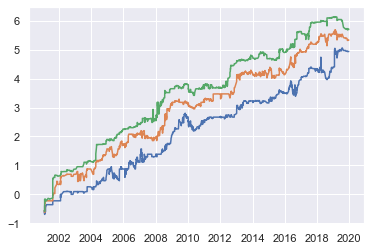

In [8]:
# plt.plot(gpu_df.rolling('365D').mean())
plt.plot(gpu_df.rolling('365D').quantile(0.5))
plt.plot(gpu_df.rolling('365D').quantile(0.75))
plt.plot(gpu_df.rolling('365D').quantile(0.9))

In [9]:
# "hyperparameter tuning"
# "best gpu Params (year_list = [4], nyears = 3, alpha = 0.1)"
# "best cpu Params (year_list = [5], nyears = 3, alpha = 0.1)"
# input_df = gpu_min_quant
# avg_mse = []
# year_lists = [[4],[4,5],[5],[4,5,6],[5,6],[6]]
# nyears = [4,5,6]
# alpha_list = [.01,.1,1,10,50]
# param_book = {}
# counter = 0
# for year_list in year_lists:
#     for nyear in nyears:
#         for alpha in alpha_list:
#             fu = pipeline.FeatureUnion([('rh',recent_hardware(gpu_df,year_list = year_list)),
#                                         ('indexer',indexer()),
#                                         ('priors',priors(min_gpu_df,nyears = nyear)),
#                                        ])

#             # fu = pipeline.FeatureUnion([('rh',recent_hardware2(cpu_df,years_back = 3)),
#             #                                ('indexer',indexer())])

#             pipe = pipeline.Pipeline([('fu',fu),
# #                                       ('norm', Normalizer()),
#                                       ('rr',Ridge(alpha = alpha))])
#             avg_mse = []
#             for column in input_df.columns:
#             # pipe.fit(inp.index,inp.values.reshape([-1,1]))
#             # pred_range = (inp.index+5)[-5:]
#             # pipe.predict(pred_range)
#                 inp = input_df[column][10:]
#                 tt = Time_cross_validation(pipe,inp,min_periods = 10,tested_periods = 10)
#                 avg_mse.append(tt.score())
#             param_book[(tuple(year_list),nyear,alpha)] = np.mean(avg_mse)
#             counter+=1
#             print(counter/(len(year_lists)*len(nyears)*len(alpha_list)))
            
# k = list(param_book)
# v = list(param_book.values())
# print(k[np.argmin(v)])
# print(v)

In [10]:
# param_book

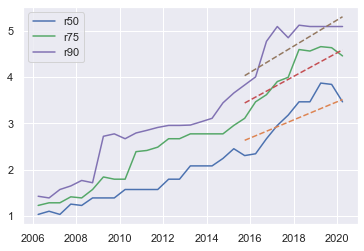

In [11]:
"CPU Comparison"
input_df = cpu_min_quant
avg_mse = []

fu = pipeline.FeatureUnion([
#                             ('rh',recent_hardware(cpu_df,year_list = [5,6])),
                            ('indexer',indexer()),
#                             ('priors',priors(min_cpu_df,nyears = 4)),
                           ])

cpu_fit_pipe = pipeline.Pipeline([('fu',fu),
                          ('rr',Ridge(alpha = 40))])

for column in input_df.columns:
    col = input_df[column][10:]
    plt.plot(col, label = column)
    cpu_fit_pipe.fit(col.index,col.values.reshape([-1,1]))
    predicts = cpu_fit_pipe.predict(col.index[-10:])
    plt.plot(col.index[-10:],predicts,linestyle = '--')
plt.legend()
plt.show()

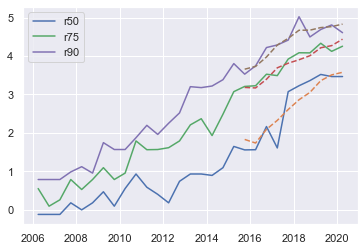

In [12]:
"GPU Comparison"
input_df = gpu_min_quant
avg_mse = []

fu = pipeline.FeatureUnion([('rh',recent_hardware(gpu_df,year_list = [4,5,6])),
                            ('indexer',indexer()),
                            ('priors',priors(min_gpu_df,nyears = 5)),
                           ])

gpu_fit_pipe = pipeline.Pipeline([('fu',fu),
#                                   ('norm',Normalizer()),
                                  ('rr',Ridge(alpha = 1))
                                 ])

# gpu_fit_pipe = pipeline.Pipeline([('fu',fu),
#                           ('dt',RandomForestRegressor(max_depth = 3))])

for column in input_df.columns:
    col = input_df[column][10:]
    plt.plot(col, label = column)
    gpu_fit_pipe.fit(col.index,col.values.reshape([-1,1]))
    predicts = gpu_fit_pipe.predict(col.index[-10:])
    plt.plot(col.index[-10:],predicts,linestyle = '--')
plt.legend()
plt.show()

In [13]:
# "CPU Prediction Model"
# color = color_gen()
# plt.figure(figsize = (16,9))
# x = cpu_min_quant.index
# # Y = [cpu_min_quant[value].values.reshape([-1,1]) for value in ['r50','r75','r90']]
# # plt.plot(x,Y[0], color = next(color))
# # plt.plot(x,Y[1], color = next(color))
# # plt.plot(x,Y[2], color = next(color))
# for col in cpu_min_quant.columns:
#     yvals = cpu_min_quant[col].values.reshape([-1,1])
#     plt.plot(x,yvals, color = next(color))

# color = color_gen()
# prediction_period = (x + 6)[-7:]
# xnew = cpu_min_quant.index[16:]
# for col in cpu_min_quant.columns:
#     Yvals = cpu_min_quant[col].values[16:].reshape([-1,1])
#     predicts = cpu_fit_pipe.fit(xnew,Yvals).predict(prediction_period).flatten()
#     predicts[0] = Yvals[-1]
#     plt.plot(prediction_period,predicts, color = next(color))

# plt.axvline("2019-09-30", color = 'k', linestyle = '--')
# plt.show()

NameError: name 'color_gen' is not defined

In [14]:
def gpu_labels():
    for x in ['Limited Selection','Most Games','Demanding Games','Nearly Anything']:
        yield(x)
def color_gen():
    colors = ['k','xkcd:grey','xkcd:light grey']
    for color in colors:
        yield color
def fill_color_gen():
    colors = sns.color_palette("coolwarm_r", 4)
    for color in colors:
        yield color

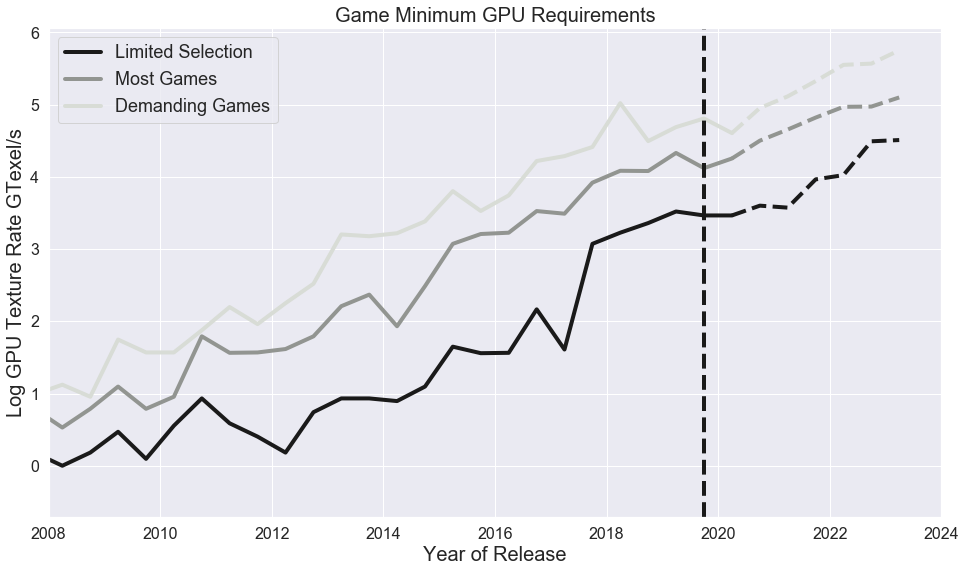

In [15]:
"GPU Prediction Model"
plt.rcParams["axes.labelsize"] = 20
plt.rcParams['xtick.labelsize'] =16
plt.rcParams['ytick.labelsize'] =16

color = color_gen()
labels = gpu_labels()
plt.figure(figsize = (16,9))
x = gpu_min_quant.index
# Y = [cpu_min_quant[value].values.reshape([-1,1]) for value in ['r50','r75','r90']]
# plt.plot(x,Y[0], color = next(color))
# plt.plot(x,Y[1], color = next(color))
# plt.plot(x,Y[2], color = next(color))
for col in gpu_min_quant.columns:
    yvals = gpu_min_quant[col].values.reshape([-1,1])
    plt.plot(x,yvals, color = next(color), label = next(labels), linewidth = 4)

color = color_gen()
prediction_period = (x + 6)[-7:]
xnew = x[10:]
for col in gpu_min_quant.columns:
    Yvals = gpu_min_quant[col].values[10:].reshape([-1,1])
    predicts = gpu_fit_pipe.fit(xnew,Yvals).predict(prediction_period).flatten()
    predicts[0] = Yvals[-1]
    plt.plot(prediction_period,predicts, color = next(color), linestyle = "--", linewidth = 4)

    
plt.fill_between
plt.axvline("2019-09-30", color = 'k', linestyle = '--', linewidth = 4)
plt.xlim('2008-01-01','2024-01-01')

plt.legend(prop={'size': 18})
plt.ylabel("Log GPU Texture Rate GTexel/s")
plt.xlabel("Year of Release")
plt.title("Game Minimum GPU Requirements", fontsize = 20)


plt.show()

'ADD IN DOT AT BOL FOR GPU LINE AND ADD GPU NAME'

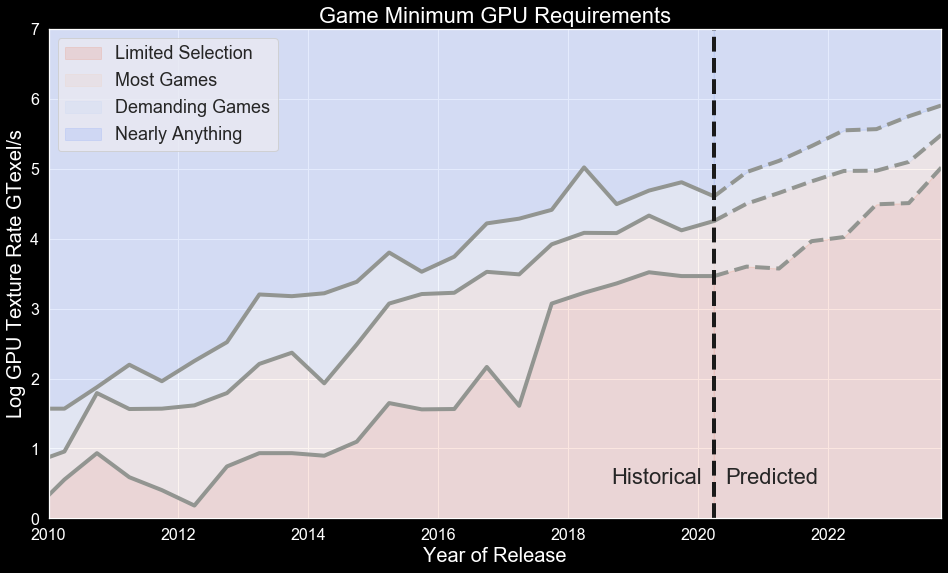

In [16]:
"GPU Prediction Model"
plt.rcParams["axes.labelsize"] = 20
plt.rcParams['xtick.labelsize'] =16
plt.rcParams['ytick.labelsize'] =16
plt.rcParams.update({
#     "lines.color": "white",
#     "patch.edgecolor": "white",
#     "text.color": "black",
#     "axes.facecolor": "white",
#     "axes.edgecolor": "lightgray",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
#     "grid.color": "lightgray",
    "figure.facecolor": "black",
    "figure.edgecolor": "black",
    "savefig.facecolor": "black",
    "savefig.edgecolor": "black"
})
color = color_gen()
labels = gpu_labels()
plt.figure(figsize = (16,9))
x = gpu_min_quant.index
# Y = [cpu_min_quant[value].values.reshape([-1,1]) for value in ['r50','r75','r90']]
# plt.plot(x,Y[0], color = next(color))
# plt.plot(x,Y[1], color = next(color))
# plt.plot(x,Y[2], color = next(color))
historical_lines = []
for col in gpu_min_quant.columns:
    yvals = gpu_min_quant[col].values.reshape([-1,1])
    historical_lines.append((x,yvals))

forecast_lines = []
prediction_period = (x + 7)[-8:]
xnew = x[10:]
forecast_lines.append((prediction_period,[0 for _ in prediction_period])) # 0 line for fill

for col in gpu_min_quant.columns:
    Yvals = gpu_min_quant[col].values[10:].reshape([-1,1])
    predicts = gpu_fit_pipe.fit(xnew,Yvals).predict(prediction_period).flatten()
    predicts[0] = Yvals[-1]
    forecast_lines.append((prediction_period,predicts))

forecast_lines.append((prediction_period,[7 for _ in prediction_period])) # 6 line for fill

color = color_gen()
labels = gpu_labels()
for x,y in historical_lines:
    plt.plot(x,y, color = 'xkcd:grey',
#              label = next(labels), 
             linewidth = 4)   
color = color_gen()
for x,y in forecast_lines[1:-1]:
    plt.plot(x,y, color = 'xkcd:grey', linestyle = "--", linewidth = 4)

color = fill_color_gen()
y_bottom = forecast_lines[0][1]
for line in forecast_lines[1:]:
    plt.fill_between(prediction_period,y_bottom,line[1], color = next(color), alpha = 0.2)
    y_bottom = line[1]

hist_x_vals= gpu_min_quant.index
y_bottom = [0 for _ in hist_x_vals]
color = fill_color_gen()

for line in historical_lines:
    line=line[1].flatten()
    plt.fill_between(hist_x_vals,y_bottom,line, 
                     color = next(color), 
                     label = next(labels),
                     alpha = 0.2)
    y_bottom = line
plt.fill_between(hist_x_vals,y_bottom,[7 for _ in hist_x_vals], 
                 color = next(color),
                 label = next(labels),
                 alpha = 0.2)    
# vertical line between historical and predictions
plt.axvline("2020-03-31", color = 'k', linestyle = '--', linewidth = 4)

#horizontal line for slected processor
# plt.plot([prediction_period[0],prediction_period[-1]],
#          [np.log(a.iloc[0]['texture_rate']),np.log(a.iloc[0]['texture_rate'])],
#         color = 'xkcd:bright red',
#          marker = 'o',
#          markerfacecolor = 'k',
#          markeredgecolor = 'k',
#          markersize = 12,
#         linewidth = 4)
# bbox_props = dict(boxstyle="square,pad=0.3", fc="xkcd:very light pink", ec="k", lw=2,alpha = 0.5)
# plt.annotate(a.iloc[0]['name'], 
#              xy=("2020-05-31", np.log(a.iloc[0]['texture_rate'])+.5),
#              size = 20,
#             bbox=bbox_props)
"historical and predicted text"
plt.annotate("Historical", 
             xy=("2018-09-01", .5),
             size = 22)
plt.annotate("Predicted", 
             xy=("2020-05-31", .5),
             size = 22)
            
            
plt.xlim('2010-01-01',prediction_period[-1])
plt.ylim(0,7)
plt.legend(prop={'size': 18})
plt.ylabel("Log GPU Texture Rate GTexel/s")
plt.xlabel("Year of Release")
plt.title("Game Minimum GPU Requirements", fontsize = 22, color = "white")

plt.savefig("talk_plot.tif")

"ADD IN DOT AT BOL FOR GPU LINE AND ADD GPU NAME"

In [58]:
prediction_period[-1]

Timestamp('2023-09-30 00:00:00', freq='2Q-DEC')

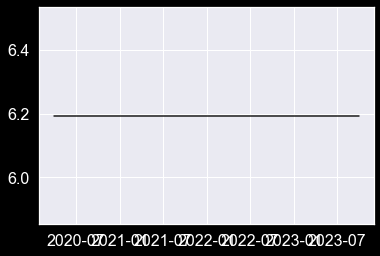

In [43]:
#horizontal line for slected processor
plt.plot([prediction_period[0],prediction_period[-1]],
         [np.log(a.iloc[0]['texture_rate']),np.log(a.iloc[0]['texture_rate'])],
        color = 'k')

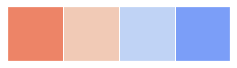

In [122]:
sns.palplot(a)

In [61]:
x

DatetimeIndex(['2001-03-31', '2001-09-30', '2002-03-31', '2002-09-30',
               '2003-03-31', '2003-09-30', '2004-03-31', '2004-09-30',
               '2005-03-31', '2005-09-30', '2006-03-31', '2006-09-30',
               '2007-03-31', '2007-09-30', '2008-03-31', '2008-09-30',
               '2009-03-31', '2009-09-30', '2010-03-31', '2010-09-30',
               '2011-03-31', '2011-09-30', '2012-03-31', '2012-09-30',
               '2013-03-31', '2013-09-30', '2014-03-31', '2014-09-30',
               '2015-03-31', '2015-09-30', '2016-03-31', '2016-09-30',
               '2017-03-31', '2017-09-30', '2018-03-31', '2018-09-30',
               '2019-03-31', '2019-09-30'],
              dtype='datetime64[ns]', freq='2Q-DEC')

In [64]:
inp.index

DatetimeIndex(['2007-03-31', '2007-09-30', '2008-03-31', '2008-09-30',
               '2009-03-31', '2009-09-30', '2010-03-31', '2010-09-30',
               '2011-03-31', '2011-09-30', '2012-03-31', '2012-09-30',
               '2013-03-31', '2013-09-30', '2014-03-31', '2014-09-30',
               '2015-03-31', '2015-09-30', '2016-03-31', '2016-09-30',
               '2017-03-31', '2017-09-30', '2018-03-31', '2018-09-30',
               '2019-03-31', '2019-09-30'],
              dtype='datetime64[ns]', freq='2Q-DEC')

In [9]:
# plot_df = linear_rec_cpu.copy()
# plot_df.name = 'tex'
# plot_df = pd.DataFrame(plot_df.reset_index())
# plot_df['year'] = plot_df['index'].apply(lambda x: x.year)
# sns.catplot(x='year', y = 'tex', data = plot_df, kind='violin', height = 4, aspect=3)
# plt.show()

In [173]:
"""
features in final matrix:
time period
different quantiles for components released in 2 years prior [.1,.25,.5,.75,.9,.95]
start with dataframe [timestamp,metric]
"""


In [270]:
input_df = cpu_min_quant['r50']
inp = input_df[7:-3]
fu = pipeline.FeatureUnion([('rh',recent_hardware(cpu_df,year_list = [3,4,5,6])),
                               ('indexer',indexer())])
pipe = pipeline.Pipeline([('fu',fu),
                          ('rr',Ridge())])
pipe.fit(inp.index,inp.values.reshape([-1,1]))
"testing"
print(f"input: \n{inp}")
print(f"In-Sample Prediction: {pipe.predict(inp.index).flatten()}")
pred_range = (inp.index+5)[-3:]
print(f"Out-Sample Range: {pred_range}")
print(f"Out-sample Predictions: {pipe.predict((pred_range)).flatten()}")
print(f"Yactual: {inp.values.flatten()[-3:]}")
dates = inp.index.append((inp.index+3)[-3:])
print(dates)
plt.plot(dates,input_df[6:].values.flatten(), label = "actual")
plt.plot(dates,pipe.predict(dates),label='predicted')
plt.legend()
plt.show()

input: 
2008-12-31    1.386294
2009-12-31    1.568616
2010-12-31    1.568616
2011-12-31    1.648659
2012-12-31    2.079442
2013-12-31    2.079442
2014-12-31    2.196978
2015-12-31    2.341806
2016-12-31    2.667228
Freq: A-DEC, Name: r50, dtype: float64
In-Sample Prediction: [1.35274228 1.50661103 1.63498156 1.78275909 1.96450653 2.10804426
 2.24613443 2.39414582 2.54715452]
Out-Sample Range: DatetimeIndex(['2019-12-31', '2020-12-31', '2021-12-31'], dtype='datetime64[ns]', freq='A-DEC')


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [155]:
gpu_min_quant['r50'][12:].index+5

DatetimeIndex(['2009-09-30', '2010-03-31', '2010-09-30', '2011-03-31',
               '2011-09-30', '2012-03-31', '2012-09-30', '2013-03-31',
               '2013-09-30', '2014-03-31', '2014-09-30', '2015-03-31',
               '2015-09-30', '2016-03-31', '2016-09-30', '2017-03-31',
               '2017-09-30', '2018-03-31', '2018-09-30', '2019-03-31',
               '2019-09-30', '2020-03-31', '2020-09-30', '2021-03-31',
               '2021-09-30', '2022-03-31'],
              dtype='datetime64[ns]', freq='2Q-DEC')

In [156]:
tst = inp.index

In [159]:
tst.append((inp.index+5)[-5:])

DatetimeIndex(['2007-03-31', '2007-09-30', '2008-03-31', '2008-09-30',
               '2009-03-31', '2009-09-30', '2010-03-31', '2010-09-30',
               '2011-03-31', '2011-09-30', '2012-03-31', '2012-09-30',
               '2013-03-31', '2013-09-30', '2014-03-31', '2014-09-30',
               '2015-03-31', '2015-09-30', '2016-03-31', '2016-09-30',
               '2017-03-31', '2017-09-30', '2018-03-31', '2018-09-30',
               '2019-03-31', '2019-09-30'],
              dtype='datetime64[ns]', freq=None)

In [113]:
(inp.index+5)[-5:]

DatetimeIndex(['2017-09-30', '2018-03-31', '2018-09-30', '2019-03-31',
               '2019-09-30'],
              dtype='datetime64[ns]', freq='2Q-DEC')

In [12]:
"FIGURE OUT HOW TO GET THE R2 SCORER TO WORK WITH NEW PIPE AND TEST"

'FIGURE OUT HOW TO GET THE R2 SCORER TO WORK WITH NEW PIPE AND TEST'

In [19]:
test = pd.date_range(inp.index[-1],periods = 10,freq = inp.index.freq)

In [20]:
test

DatetimeIndex(['2019-09-30', '2020-03-31', '2020-09-30', '2021-03-31',
               '2021-09-30', '2022-03-31', '2022-09-30', '2023-03-31',
               '2023-09-30', '2024-03-31'],
              dtype='datetime64[ns]', freq='2Q-DEC')

In [31]:
inp = gpu_min_quant['r90'].index
fu = pipeline.FeatureUnion([('rh',recent_hardware(gpu_df,year_list = [3,4,5,6])),
                               ('indexer',indexer())])
pipe = pipeline.Pipeline([('fu',fu),
                          ('rr',Ridge())])

tt = Time_cross_validation(pipe,pd.DataFrame(inp),min_periods = 16,tested_periods = 10)
tt.score()
# time_steps = np.array(range((len(cpu_min_quant[quantile_name])))).reshape([-1,1])
# # X = np.concatenate((time_steps,time_steps**2,time_steps**3,time_steps**4),axis=1)
# X = time_steps
# Y = cpu_min_quant[quantile_name]
# model.fit(X,Y)
# print(model.score(X,Y))
# predicts = model.predict(X)
# plt.plot(time_steps.flatten(),Y)
# plt.plot(time_steps.flatten(),predicts)
# plt.show()

            0
0  2001-03-31
1  2001-09-30
2  2002-03-31
3  2002-09-30
4  2003-03-31
5  2003-09-30
6  2004-03-31
7  2004-09-30
8  2005-03-31
9  2005-09-30
10 2006-03-31
11 2006-09-30
12 2007-03-31
13 2007-09-30
14 2008-03-31
15 2008-09-30


TypeError: unsupported operand type(s) for -: 'int' and 'Timedelta'

In [28]:
tt.score()

            0
0  2001-03-31
1  2001-09-30
2  2002-03-31
3  2002-09-30
4  2003-03-31
5  2003-09-30
6  2004-03-31
7  2004-09-30
8  2005-03-31
9  2005-09-30
10 2006-03-31
11 2006-09-30
12 2007-03-31
13 2007-09-30
14 2008-03-31
15 2008-09-30


TypeError: unsupported operand type(s) for -: 'int' and 'Timedelta'

In [ ]:
for quantile_name in ["r10",'r25','r50','r75','r90']:
    model = Ridge()
    time_steps = np.array(range((len(cpu_min_quant[quantile_name])))).reshape([-1,1])
    # X = np.concatenate((time_steps,time_steps**2,time_steps**3,time_steps**4),axis=1)
    X = time_steps
    Y = cpu_min_quant[quantile_name]
    model.fit(X,Y)
    print(model.score(X,Y))
    predicts = model.predict(X)
    plt.plot(time_steps.flatten(),Y)
    plt.plot(time_steps.flatten(),predicts)
plt.show()

In [ ]:
r2 = []
for col in linear_rec_cpu_df.columns:
    

In [ ]:
"Model Validation"
# model = Arima(order = (2,2,1))
# model.fit(pd.DataFrame(linear_rec_cpu_df['r90']))
r2 = []
for order in permutations([0,1,2,3,4,6],3):
    model = Arima(order = order)
    try:
        tt = Time_cross_validation(model,pd.DataFrame(linear_rec_cpu_df['r']),min_periods = 12,tested_periods = 5)
        tt.splits()
        r2.append([order,tt.score()])
    except:
        pass
r2

In [ ]:
"Model Validation"
# model = Arima(order = (2,2,1))
# model.fit(pd.DataFrame(linear_rec_cpu_df['r90']))
r2 = []
test_df = linear_rec_cpu_df
for col in test_df:
    model = Arima(order = (1,0,0),train=True)
    try:
        tt = Time_cross_validation(model,pd.DataFrame(linear_rec_cpu_df[col]),min_periods = 10,tested_periods = 10)
        tt.splits()
        r2.append([col,tt.score()])
    except:
        pass
r2

In [ ]:
"Using input dataframe create a model/prediction for each series as a dictionary"
input_df = linear_rec_gpu_df
prediction_steps = 10
predict_index = [input_df.index[-1] + period for period in range(1,prediction_steps+1)]
models = {}
for name,data in input_df.iteritems():
    temp_model = Arima(order = (2,1,0)).fit(pd.DataFrame(data))
    models[name] = {"model": temp_model}
    models[name].update({"full_data":input_df[name].append(pd.DataFrame(temp_model.predict(num_steps = prediction_steps), index = predict_index)),
                        "standard_error":temp_model.predict(std_error = True)})

In [ ]:
plt.plot(models['r90']['full_data'], color='lightgray', linestyle="--")
plt.plot(models['r10']['full_data'], color='lightgray', linestyle="--")
plt.plot(models['r50']['full_data'], 'k-')
plt.fill_between(models['r50']['full_data'].index, 
                 models['r50']['full_data'].values.flatten(),
                 models['r75']['full_data'].values.flatten(),
                alpha = 0.3,
                color = 'b')
plt.fill_between(models['r50']['full_data'].index, 
                 models['r50']['full_data'].values.flatten(),
                 models['r25']['full_data'].values.flatten(),
                alpha = 0.3,
                color = 'b')
plt.axvline("2019-09-30", color = 'k', linestyle = '--')
plt.xlim('2001-01-01','2025-01-01')
plt.plot()

In [ ]:
models['r90'].predict()

In [ ]:
predictions = pd.DataFrame(index = [])

In [ ]:
# linear_rec_gpu_df
# [col for col in linear_rec_gpu_df.columns]
[col for col in linear_rec_gpu_df[]]

In [ ]:

plt.plot(list(range(10)),[np.exp(v) for v in value])
plt.plot(list(range(10)),[np.exp(lc) for lc in conf[:,0]], "--")
plt.plot(list(range(10)),[np.exp(uc) for uc in conf[:,1]], "--")
plt.show()

In [ ]:
linear_rec_gpu_df.index

In [ ]:
model.get

In [ ]:
cpu_resampled.values.flatten()

In [ ]:
param_eval

In [ ]:
cpu_resampled = pd.DataFrame(cpu_df['flops'].resample("Y"))
cpu_resampled['log_flops'] = linearized(cpu_resampled['flops'].values)
# cpu_resampled['log_flops'].plot()

In [ ]:
cpu

In [ ]:
from statsmodels.tsa.arima_model import ARIMA as ar

In [ ]:
gpu_df_biannual['log_tex']

In [ ]:
model = ar(gpu_df_biannual['log_tex'].values,order=(3,1,0))
fitted = model.fit(disp=0)

In [ ]:
residuals = pd.DataFrame(fitted.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())
print(fitted.summary())

In [ ]:
param_eval = {}
for p in range(4):
    for d in range(4):
        for q in range(4):
            try:
                param_eval[(p,d,q)] = ar(gpu_df_biannual['log_tex'].values,order=(p,d,q)).fit().aic
            except:
                pass
"BEST FIT WAS P,D,Q = 3,1,0"

In [ ]:
fitted.plot_predict()

In [2]:
plt.figure(figsize = (15,10))
plt.rcParams["axes.labelsize"] = 20
plt.rcParams['xtick.labelsize'] =16
plt.rcParams['ytick.labelsize'] =16
period = "2BQ"
"BOTH GAME TEXTURE RATES ARE FROM RECOMMENDED REQUIREMENTS"
gpu_df['Texture Rate'].resample(period).mean().plot(label = "Mean GPU Texture Rate",style='--')
gpu_df['Texture Rate'].resample(period).max().plot(style='--', label = "Max GPU Texture Rate")
# min_gpu_df.resample(period).max().plot(label = "Max Minimum Req GPU Texture Rate")
rec_gpu_df.resample(period).max().plot(label = "Max Game GPU Texture Rate")
# min_gpu_df.resample(period).mean().plot(style='.',label = "Mean Minimum Req GPU Texture Rate")
rec_gpu_df.resample(period).mean().plot(style='-',label = "Mean Game GPU Texture Rate")
plt.legend(prop={'size': 18})
plt.yscale('log')
plt.ylabel("Log GPU Texture Rate GTexel/s")
plt.xlabel("Year of Release")
plt.title("Biannually Sampled Component and Game GPU Specs", fontsize = 20)
plt.xlim('2000-12-01','2019-01-01')
plt.show()

NameError: name 'plt' is not defined

In [ ]:
'simplifed CPU plot'
plt.figure(figsize = (15,10))
period = "Y"

cpu_df['flops'].resample(period).mean().plot(label = "Mean Hardware Performance")
rec_cpu_df.resample(period).mean().plot(style='--',label = "Mean Game Requirements")
plt.title("Yearly Sampled Component and Game CPU Specs", fontsize = 20)
plt.legend(prop={'size': 18})
plt.yscale('log')
plt.ylabel("Log CPU GFLOPS")
# plt.xlim('2000-12-01','2019-01-01')
plt.xlabel("Year of Release")
plt.show()

In [ ]:
plt.figure(figsize = (10,5))
period = "Y"
cpu_df['flops'].resample(period).mean().plot(label = "Hardware Performance", linewidth = 4)
# cpu_df['flops'].resample(period).max().plot( label = "Max CPU GFLOPS")
# min_cpu_df.resample(period).max().plot(style='--', label = "Max Minimum Game CPU GFLOPS Max")
# rec_cpu_df.resample(period).max().plot(style='--', label = "Max Game CPU GFLOPS")
# min_cpu_df.resample(period).mean().plot(style='.',label = "Mean Minimum Game CPU GFLOPS Max")
rec_cpu_df.resample(period).mean().plot(style='--',label = "Game Requirements", linewidth = 4)
plt.title("Average Yearly Sampled Hardware and Game CPU Specs", fontsize = 20)
plt.legend(prop={'size': 18})
plt.yscale('log')
plt.ylabel("Log CPU GFLOPS")
plt.xlim('2000-12-01','2019-01-01')
plt.xlabel("Year of Release")
plt.xticks(list(pd.date_range('2000-01-01', periods=11, freq='2Y')),labels = list(range(2000,2021,2)))

plt.show()

In [ ]:
help(plt.xticks)

In [ ]:
# plt.figure(figsize = (15,10))
period = "Y"
hardware_resampled = cpu_df['flops'].resample(period).mean()
# cpu_df['flops'].resample(period).max().plot( label = "Max CPU GFLOPS")
# min_cpu_df.resample(period).max().plot(style='--', label = "Max Minimum Game CPU GFLOPS Max")
# rec_cpu_df.resample(period).max().plot(style='--', label = "Max Game CPU GFLOPS")
# min_cpu_df.resample(period).mean().plot(style='.',label = "Mean Minimum Game CPU GFLOPS Max")
game_resampled = rec_cpu_df.resample(period).mean()
# plt.title("Yearly Sampled Component and Game CPU Specs", fontsize = 20)
# plt.legend(prop={'size': 18})
# plt.yscale('log')
# plt.ylabel("Log CPU GFLOPS")
# plt.xlim('2000-12-01','2019-01-01')
# plt.xlabel("Year of Release")
# plt.xticks("")
# plt.show()

In [ ]:
hardware_resampled.index

In [ ]:
help(pd.datetime)

In [ ]:
list(pd.date_range('2000-01-01', periods=20, freq='Y'))

In [ ]:
list(pd.date_range('2000-01-01', periods=11, freq='2Y'))